In [1]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.electronic_structure.plotter import BSPlotter
import matplotlib.pyplot as plt

In [2]:
mp_key = "kqoGOG3L85VvUgz1hujhLArYSrmj87fq"
mp_id = "mp-10182"

In [3]:
with MPRester(mp_key) as m:
    el_bs = m.get_bandstructure_by_material_id(mp_id)

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

# Bande interdite 

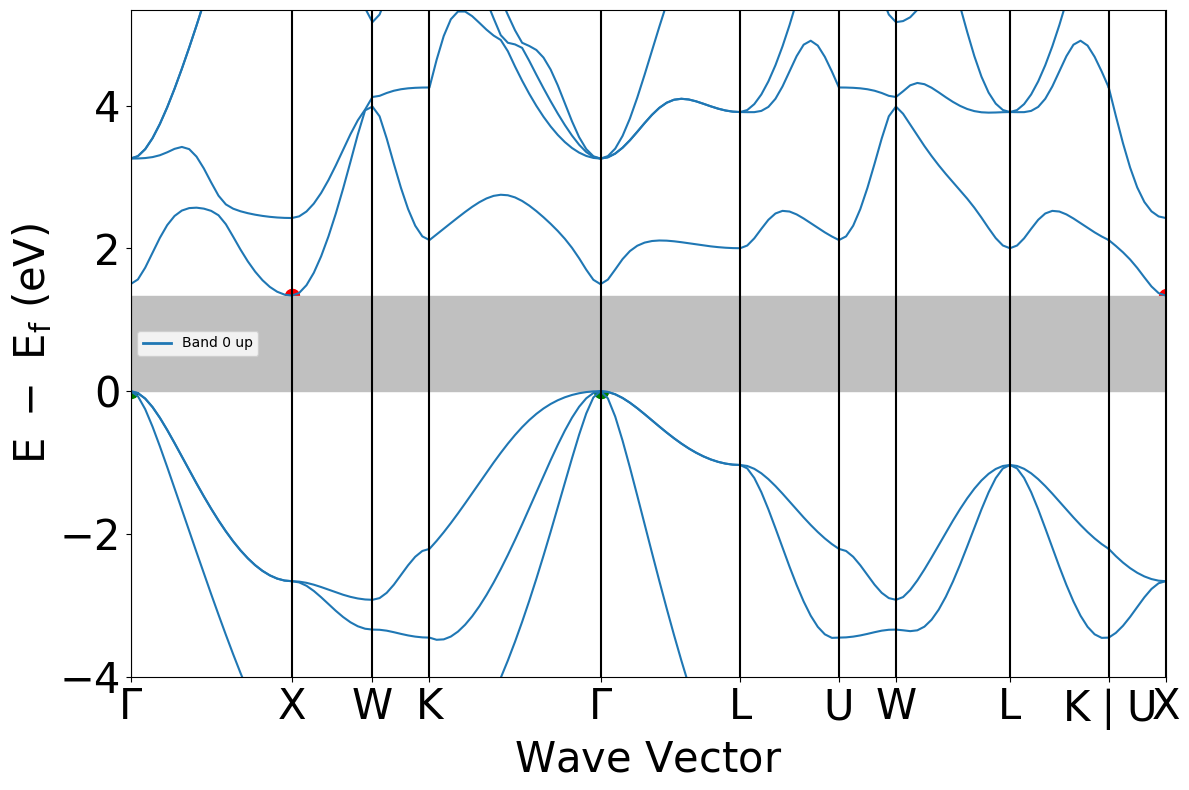

In [4]:
plot = BSPlotter(el_bs)
plot.get_plot(vbm_cbm_marker=True)

#Bande interdite
plot_data = BSPlotter(el_bs).bs_plot_data()
data = plot_data.get('ticks').get('distance')
gap = el_bs.get_band_gap()
gap_energy = gap['energy']
plt.fill_between(np.linspace(data[0], data[-1], 400), 0, gap_energy, color = 'silver')

In [5]:
print(gap)

{'direct': False, 'energy': 1.3386, 'transition': '\\Gamma-X'}


La bande interdite est indirecte, ce qui signifie que le minimum de la bande de conduction (point rouge) et le maximum de la bande de valence (point vert) ne se produisent pas au même vecteur d'onde dans l'espace réciproque.

L'énergie de cette bande est de 1.3386eV. C'est l'énergie nécessaire pour exciter un électron de la bande de valence à la bande de conduction. Ici, nous avons une énergie typique des semi-conducteurs.

La transition électronique se fera de $\Gamma$ à $X$ dans l'espace réciproque.

# Dernière bande de valence

In [6]:
vbm = el_bs.get_vbm()
data = BSPlotter(el_bs).bs_plot_data()
E_0 = data.get('zero_energy')
E_vbm = vbm['energy']
kpoint_vbm = vbm['kpoint'].cart_coords

print('Energie du maximum de la bande de valence : {} eV'.format(E_vbm))
print(vbm.get('band_index'))

Energie du maximum de la bande de valence : 3.1755 eV
defaultdict(<class 'list'>, {<Spin.up: 1>: [7, 8, 9]})


L'énergie maximum de la bande de valence (3.1755 eV) est contenue sur les bandes 7, 8 et 9. Ce maximum correspond au point vert sur le graphe ci-dessus. On peut donc considérer que la dernière bande de valence est la bande 9.

# Première bande de conduction

In [7]:
cbm = el_bs.get_cbm()
E_cbm = cbm['energy']
kpoint_cbm = cbm['kpoint'].cart_coords

print('Energie du minimum de la bande de conduction :',E_cbm,'eV')
print(cbm.get('band_index'))

Energie du minimum de la bande de conduction : 4.5141 eV
defaultdict(<class 'list'>, {<Spin.up: 1>: [10]})


L'énergie minimum de la bande de conduction (4.5141 eV) est contenue sur la bande 10. Ce minimum correspond au point rouge sur le graphe ci-dessus.

# Direction de dispertion

En valeur absolue:
Pente de la plus grande dispersion pour la bande de valence:      2.4474261675026914 (en rouge)
Pente de la plus grande dispersion pour la bande de conduction:   4.851521449728386 (en vert)
Pente de la plus faible dispersion pour la bande de valence:      0.47798602020670306 (en bleu)
Pente de la plus faible dispersion pour la bande de conduction:   0.14662147859101327 (en jaune)


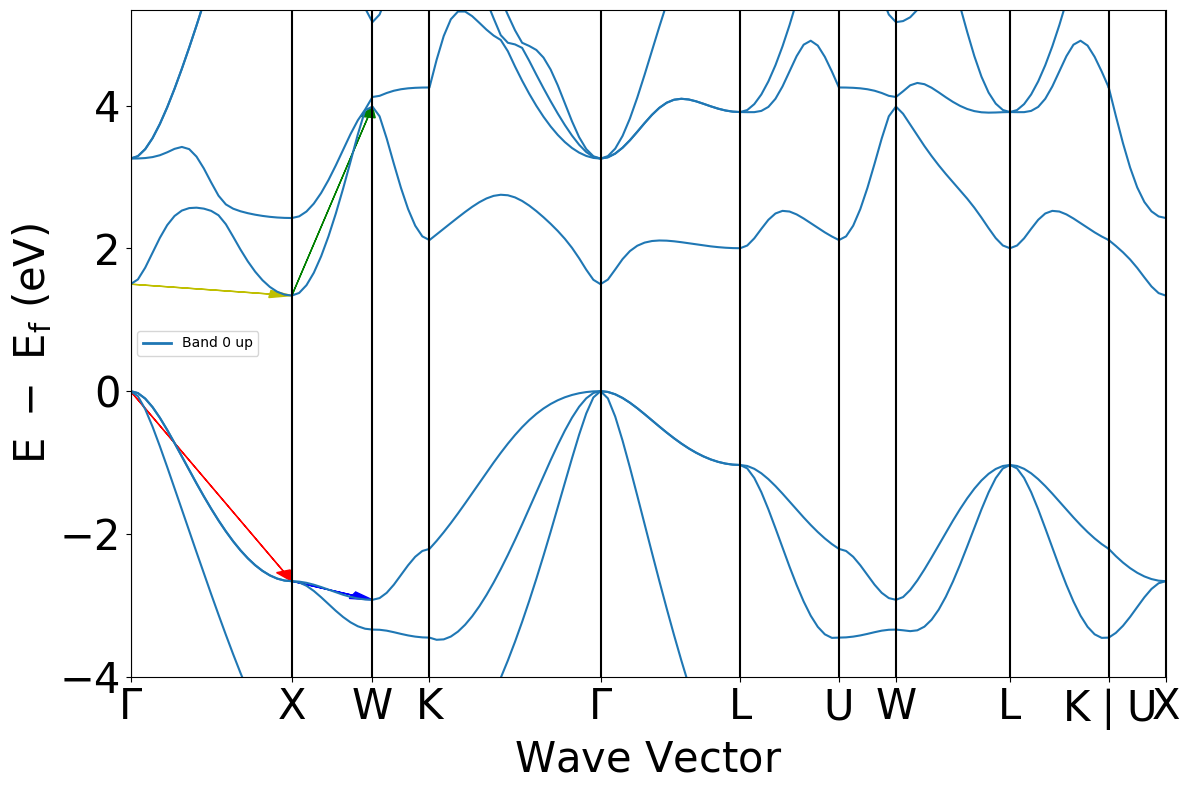

In [8]:
x = data.get('ticks').get('distance')
x = np.array([x[0], x[1], x[3], x[5], x[7], x[9], x[11], x[13], x[15], x[17], x[18]]) 
y = data.get('energy')

dx = np.zeros(10)
dy_cond = np.zeros(10)
dy_val = np.zeros(10)
p_cond = np.zeros(10)
p_val = np.zeros(10)

for i in range(10):
    dx[i] = x[i+1] - x[i]
    
for i in range(10):
    dy_val[i] =y.get('1')[i][9][-1] - y.get('1')[i][9][0]
    dy_cond[i] =y.get('1')[i][10][-1] - y.get('1')[i][10][0]
    
for i in range (10):
    p_cond[i] = dy_cond[i]/dx[i]
    p_val[i] = dy_val[i]/dx[i] 
    
print("En valeur absolue:")
mxV = np.max(abs(p_val))
print("Pente de la plus grande dispersion pour la bande de valence:     ", mxV, "(en rouge)")
mxC = np.max(abs(p_cond))
print("Pente de la plus grande dispersion pour la bande de conduction:  ", mxC, "(en vert)")
mnV = np.min(abs(p_val))
print("Pente de la plus faible dispersion pour la bande de valence:     ", mnV, "(en bleu)")
mnC = np.min(abs(p_cond))
print("Pente de la plus faible dispersion pour la bande de conduction:  ", mnC, "(en jaune)")

BSPlotter(el_bs).get_plot()
plt.arrow(x[0], (y.get('1')[0][9])[0], dx[0], dy_val[0], color = 'r', head_width = 0.1,length_includes_head=True)
plt.arrow(x[1], (y.get('1')[1][9])[0], dx[1], dy_val[1], color = 'b', head_width = 0.1,length_includes_head=True)
plt.arrow(x[1], (y.get('1')[1][10])[0], dx[1], dy_cond[1], color = 'g', head_width = 0.1,length_includes_head=True)
plt.arrow(x[0], (y.get('1')[0][10])[0], dx[0], dy_cond[0], color = 'y', head_width = 0.1,length_includes_head=True)
plt.show()

# Masse effective

La masse effective est utilisée pour décrire le comportement des porteurs de charge dans un matériau cristallin sous l'influence d'un champ électrique ou magnétique. Elle est inversement proportionnelle à la courbure de la dispersion de l'énergie dans l'espace des k.

$$m^* = (\frac{\delta^2 E}{\delta k_i\delta k_j})^{-1} = \frac{\hbar^2 \cdot |k|^2}{2E}$$


In [9]:
h_bar = 6.5821e-16

k_coord_val = el_bs.get_vbm().get('kpoint').frac_coords
m_vbm = (h_bar**2 * (k_coord_val[0]**2+k_coord_val[1]**2+k_coord_val[2]**2))/(2*abs(E_vbm))
print('Masse effective au sommet de la dernière bande de valence : {} kg.'.format(m_vbm))

k_coord_cond = el_bs.get_cbm().get('kpoint').frac_coords
m_cbm = (h_bar**2 * (k_coord_cond[0]**2+k_coord_cond[1]**2+k_coord_cond[2]**2))/(2*abs(E_cbm))
print('Masse effective au bas de la première bande de conduction : {} kg.'.format(m_cbm))

Masse effective au sommet de la dernière bande de valence : 0.0 kg.
Masse effective au bas de la première bande de conduction : 2.399373098181254e-32 kg.
